As a reference for tests in MEMP_testook.ipynb

In [6]:
from memo import memo
import jax.numpy as jnp
import jax
from enum import IntEnum
import numpy as np
from jax.scipy.special import logsumexp
from typing import Union
from scipy.special import gammaln, logsumexp, softmax
from enum import IntEnum
from memo.lib import * 
import matplotlib.pyplot as plt

from world_jax import WorldJAX
from _rsa_agents import * 
from rsa_memo import *
from test_utils import *

### b] reproduce figure 3

In [9]:
world = World(
    n=1,
    m=7,
    theta_values=np.linspace(0, 1, 11)  
)

observations = world.observations
utterances = world.utterances
n_obs = len(observations)
n_utt = len(utterances)

utterance_target = 'some,successful'
u_idx = world.utterances.index(utterance_target)

In [13]:
l0 = LiteralListener(world)
l1_cred = create_listener(
    world=world,
    level=1,
    omega="coop",          # same world type as speaker
    update_internal=True,
    alpha=3.0
)
l1_vig = create_listener(
    world=world,
    level=1,
    omega="strat",        
    update_internal=True,
    alpha=3.0,
    initial_beliefs_psi=np.array([1/3, 1/3, 1/3])  # uniform over pers-, inf, pers+
)

l0.listen_and_update(utterance_target)
l1_cred.listen_and_update(utterance_target)
l1_vig.listen_and_update(utterance_target)

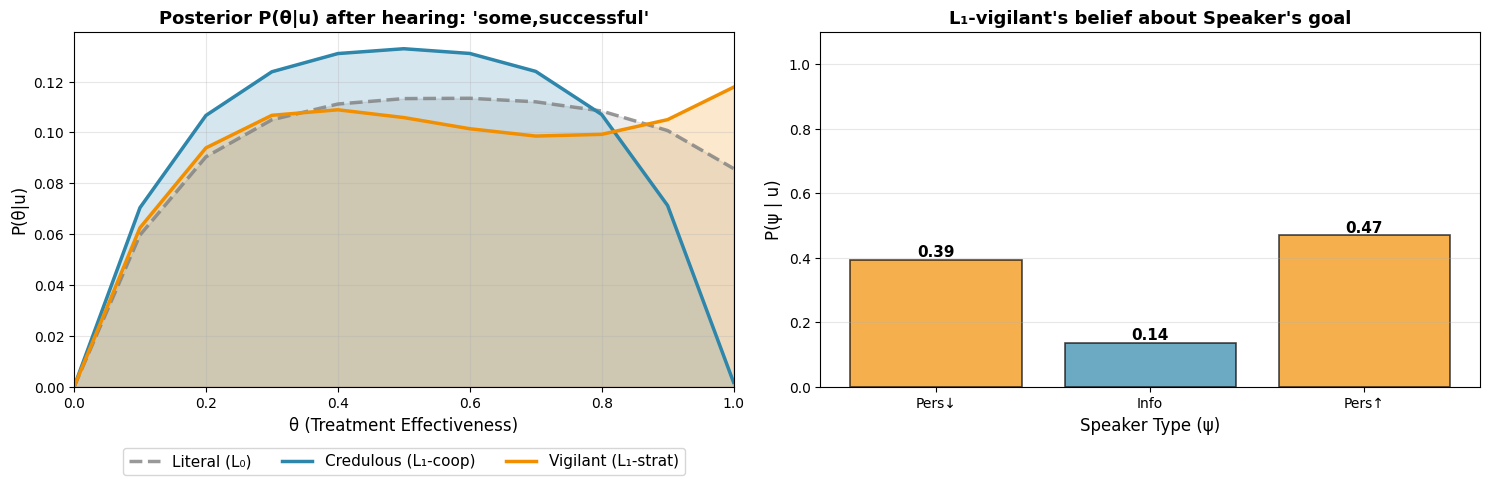

=== Posterior Beliefs after hearing 'some,successful' ===
Expected θ:
  L0 (Literal):           0.566
  L1_cred (Credulous):    0.501
  L1_vig (Vigilant):      0.575

L1_vig's belief about Speaker's goal:
  P(Speaker wants to persuade down) = 0.394
  P(Speaker is credible/informative) = 0.136
  P(Speaker wants to persuade up)    = 0.469


In [17]:
# Plotting & Analyzing
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
theta_vals = world.theta_values

# Plot 1: P(θ|u) for different listeners
ax = axes[0]
ax.plot(theta_vals, l0.current_belief_theta, '--', color='gray', linewidth=2.5, label='Literal (L₀)', alpha=0.8)
ax.plot(theta_vals, l1_cred.current_belief_theta, '-', color='#2E86AB', linewidth=2.5, label='Credulous (L₁-coop)')
ax.plot(theta_vals, l1_vig.current_belief_theta, '-', color='#F18F01', linewidth=2.5, label='Vigilant (L₁-strat)')

# Fill areas under curves
ax.fill_between(theta_vals, 0, l0.current_belief_theta, alpha=0.15, color='gray')
ax.fill_between(theta_vals, 0, l1_cred.current_belief_theta, alpha=0.2, color='#2E86AB')
ax.fill_between(theta_vals, 0, l1_vig.current_belief_theta, alpha=0.2, color='#F18F01')

ax.set_xlabel('θ (Treatment Effectiveness)', fontsize=12)
ax.set_ylabel('P(θ|u)', fontsize=12)
ax.set_title(f"Posterior P(θ|u) after hearing: '{utterance_target}'", fontsize=13, fontweight='bold')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=True, fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, None])

# Plot 2: P(psi|u) for L1_vig
ax = axes[1]
psi_labels = ['Pers↓', 'Info', 'Pers↑']
colors = ['#F18F01', '#2E86AB', '#F18F01']
bars = ax.bar(psi_labels, l1_vig.current_belief_psi, color=colors, alpha=0.7, edgecolor='black', linewidth=1.2)

# Add value labels on top of bars
for i, (bar, val) in enumerate(zip(bars, l1_vig.current_belief_psi)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('P(ψ | u)', fontsize=12)
ax.set_xlabel('Speaker Type (ψ)', fontsize=12)
ax.set_title(f"L₁-vigilant's belief about Speaker's goal", fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.1])  # Extra space for labels

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"=== Posterior Beliefs after hearing '{utterance_target}' ===")
print(f"Expected θ:")
print(f"  L0 (Literal):           {jnp.sum(l0.current_belief_theta * theta_vals):.3f}")
print(f"  L1_cred (Credulous):    {jnp.sum(l1_cred.current_belief_theta * theta_vals):.3f}")
print(f"  L1_vig (Vigilant):      {jnp.sum(l1_vig.current_belief_theta * theta_vals):.3f}")
print(f"\nL1_vig's belief about Speaker's goal:")
print(f"  P(Speaker wants to persuade down) = {l1_vig.current_belief_psi[0]:.3f}")
print(f"  P(Speaker is credible/informative) = {l1_vig.current_belief_psi[1]:.3f}")
print(f"  P(Speaker wants to persuade up)    = {l1_vig.current_belief_psi[2]:.3f}")

### d] simulation loop that runs 1000 simulations × 100 rounds

Figures 4-7 need a simulation loop that runs 1000 simulations × 100 rounds, tracks E[θ] and MAP estimates per round, and computes bias and std across runs (hopefully this will be a lot faster now so it'd be cool to timeit!)

4 pairings:
1. **Informative S₁ × Credulous L₁**
2. **Informative S₁ × Vigilant L₁**
3. **Persuasive-down S₁ × Credulous L₁**
4. **Persuasive-down S₁ × Vigilant L₁**

Each simulation: 1000 runs × 100 rounds

**NOTES: HAVE TO RE-RUN world setup bc NOW RUNNING ON DIFFERENT WORLD**

##### Setup World for Simulation (n=5, m=7)

In [10]:
# Create world for simulation (same as MEMO version)
world_sim = World(
    n=5,
    m=7,
    theta_values=np.linspace(0, 1, 10)  # 10 theta values from 0 to 1
)

print(f"World created: n={world_sim.n}, m={world_sim.m}")
print(f"Number of theta values: {len(world_sim.theta_values)}")
print(f"Number of observations: {len(world_sim.observations)}")
print(f"Number of utterances: {len(world_sim.utterances)}")

World created: n=5, m=7
Number of theta values: 10
Number of observations: 792
Number of utterances: 32


##### Simulation Functions

In [11]:
import time
from tqdm import tqdm
import pandas as pd

def compute_expected_theta(posterior, theta_values):
    """Compute E[θ] given posterior distribution"""
    return np.sum(posterior * theta_values)

def compute_map_theta(posterior, theta_values):
    """Compute MAP estimate of θ"""
    map_idx = np.argmax(posterior)
    return theta_values[map_idx]

def run_single_dyad_simulation_base(
    true_theta: float,
    speaker_type: str,  # 'inf' or 'pers_down'
    listener_type: str,  # 'cred' or 'vig'
    world: World,
    n_rounds: int,
    run_seed: int,
    alpha: float = 3.0
):
    """
    Run single simulation using BASE (non-memo) agents.
    Key: Create NEW agents each round with updated prior!
    """
    # Initialize
    theta_values = world.theta_values
    
    # Storage
    expected_thetas = []
    map_thetas = []
    observations_list = []
    utterances_list = []
    
    # Sample observations for this run
    np.random.seed(run_seed)
    theta_idx = np.argmin(np.abs(theta_values - true_theta))
    obs_probs = np.exp(world.obs_log_likelihood_theta.iloc[:, theta_idx].values)
    
    for round_idx in range(n_rounds):
        # 1. Sample observation
        obs_idx = np.random.choice(len(world.observations), p=obs_probs)
        obs = world.observations[obs_idx]
        observations_list.append(obs)
        
        # 2. Create speaker (uses listener's current belief as prior)
        if speaker_type == 'inf':
            speaker = create_speaker(
                world=world,
                level=1,
                omega="coop",
                psi="inf",
                update_internal=False,
                alpha=alpha,
                beta=1.0
            )
        elif speaker_type == 'pers_down':
            speaker = create_speaker(
                world=world,
                level=1,
                omega="strat",
                psi="pers-",
                update_internal=False,
                alpha=alpha,
                beta=0.0
            )
        else:
            raise ValueError(f"Unknown speaker type: {speaker_type}")
        
        # 3. Speaker produces utterance (update_and_speak returns the utterance)
        utterance = speaker.update_and_speak(obs)  # ← FIX: directly get returned value
        utterances_list.append(utterance)
        
        # 4. Create listener and update belief
        if listener_type == 'cred':
            listener = create_listener(
                world=world,
                level=1,
                omega="coop",
                update_internal=False,
                alpha=alpha
            )
        elif listener_type == 'vig':
            listener = create_listener(
                world=world,
                level=1,
                omega="strat",
                update_internal=False,
                alpha=alpha,
                initial_beliefs_psi=np.array([1/3, 1/3, 1/3])
            )
        else:
            raise ValueError(f"Unknown listener type: {listener_type}")
        
        # Listener hears utterance and updates
        listener.listen_and_update(utterance)
        posterior = listener.current_belief_theta
        
        # 5. Compute statistics
        expected_theta = compute_expected_theta(posterior, theta_values)
        map_theta = compute_map_theta(posterior, theta_values)
        
        expected_thetas.append(float(expected_theta))
        map_thetas.append(float(map_theta))
        
        # 6. Update prior for next round (speaker will use this)
        # Note: In base version, we'd need to set this on the next speaker
        # For now, we're not implementing full Bayesian updating like MEMO
    
    return {
        'expected_theta': expected_thetas,
        'map_theta': map_thetas,
        'observations': observations_list,
        'utterances': utterances_list
    }

def run_dyad_simulations_base(
    pairing_name: str,
    true_theta: float,
    speaker_type: str,
    listener_type: str,
    world: World,
    n_runs: int = 1000,
    n_rounds: int = 100,
    base_seed: int = 42,
    alpha: float = 3.0
):
    """Run multiple simulations for BASE version."""
    print(f"\n{'='*60}")
    print(f"[BASE] Running: {pairing_name}")
    print(f"True θ = {true_theta:.2f} | Runs = {n_runs} | Rounds = {n_rounds}")
    print(f"{'='*60}")
    
    start_time = time.time()
    all_results = []
    
    for run_id in tqdm(range(n_runs), desc=f"Running {pairing_name}"):
        run_seed = base_seed + run_id
        
        # Run single simulation
        run_results = run_single_dyad_simulation_base(
            true_theta=true_theta,
            speaker_type=speaker_type,
            listener_type=listener_type,
            world=world,
            n_rounds=n_rounds,
            run_seed=run_seed,
            alpha=alpha
        )
        
        # Store results
        for round_idx in range(n_rounds):
            all_results.append({
                'pairing': pairing_name,
                'run_id': run_id,
                'round': round_idx,
                'expected_theta': run_results['expected_theta'][round_idx],
                'map_theta': run_results['map_theta'][round_idx],
                'observation': run_results['observations'][round_idx],
                'utterance': run_results['utterances'][round_idx]
            })
    
    total_time = time.time() - start_time
    
    print(f"\n{'─'*60}")
    print(f"⏱  TIMING SUMMARY")
    print(f"{'─'*60}")
    print(f"  Total time:           {total_time:.2f}s ({total_time/60:.2f} min)")
    print(f"  Avg per run:          {total_time/n_runs:.4f}s")
    print(f"  Avg per round:        {total_time/(n_runs*n_rounds):.4f}s")
    print(f"  Throughput:           {n_runs*n_rounds/total_time:.1f} rounds/sec")
    print(f"{'─'*60}\n")
    
    return pd.DataFrame(all_results)

def compute_bias_and_std(results_df, true_theta):
    """Compute bias and std across runs for each round."""
    stats = []
    
    for round_idx in results_df['round'].unique():
        round_data = results_df[results_df['round'] == round_idx]
        
        expected_vals = round_data['expected_theta'].values
        mean_expected = np.mean(expected_vals)
        bias_expected = mean_expected - true_theta
        std_expected = np.std(expected_vals)
        
        map_vals = round_data['map_theta'].values
        mean_map = np.mean(map_vals)
        bias_map = mean_map - true_theta
        std_map = np.std(map_vals)
        
        stats.append({
            'round': round_idx,
            'mean_expected': mean_expected,
            'bias_expected': bias_expected,
            'std_expected': std_expected,
            'mean_map': mean_map,
            'bias_map': bias_map,
            'std_map': std_map
        })
    
    return pd.DataFrame(stats)

print("✓ BASE simulation functions loaded!")

✓ BASE simulation functions loaded!


##### Run Simulations (True θ = 0.6)

In [12]:
# Simulation parameters
TRUE_THETA = 0.6  # Set to 0.6 as requested
N_RUNS = 1000
N_ROUNDS = 100
ALPHA_VAL = 3.0
BASE_SEED = 42

# Define 4 pairings
pairings = [
    {'name': 'S1_inf × L1_cred', 'speaker': 'inf', 'listener': 'cred'},
    {'name': 'S1_inf × L1_vig', 'speaker': 'inf', 'listener': 'vig'},
    {'name': 'S1_pers_down × L1_cred', 'speaker': 'pers_down', 'listener': 'cred'},
    {'name': 'S1_pers_down × L1_vig', 'speaker': 'pers_down', 'listener': 'vig'},
]

# Storage
all_results_base = {}
all_statistics_base = {}

print(f"\n{'#'*70}")
print(f"# BASE VERSION DYADIC SIMULATION EXPERIMENTS")
print(f"# True θ = {TRUE_THETA}")
print(f"# {N_RUNS} runs × {N_ROUNDS} rounds per pairing")
print(f"{'#'*70}\n")

overall_start = time.time()

# Run simulations for each pairing
for pairing in pairings:
    results_df = run_dyad_simulations_base(
        pairing_name=pairing['name'],
        true_theta=TRUE_THETA,
        speaker_type=pairing['speaker'],
        listener_type=pairing['listener'],
        world=world_sim,
        n_runs=N_RUNS,
        n_rounds=N_ROUNDS,
        base_seed=BASE_SEED,
        alpha=ALPHA_VAL
    )
    
    # Compute statistics
    stats_df = compute_bias_and_std(results_df, TRUE_THETA)
    
    # Store results
    all_results_base[pairing['name']] = results_df
    all_statistics_base[pairing['name']] = stats_df
    
    # Print summary
    final_round = stats_df.iloc[-1]
    print(f"\n  Final Round ({N_ROUNDS}) Statistics:")
    print(f"    E[θ]: mean={final_round['mean_expected']:.4f}, bias={final_round['bias_expected']:.4f}, std={final_round['std_expected']:.4f}")
    print(f"    MAP: mean={final_round['mean_map']:.4f}, bias={final_round['bias_map']:.4f}, std={final_round['std_map']:.4f}")

total_elapsed = time.time() - overall_start

print(f"\n{'='*70}")
print(f"ALL BASE SIMULATIONS COMPLETED!")
print(f"Total time: {total_elapsed:.2f} seconds ({total_elapsed/60:.2f} minutes)")
print(f"{'='*70}\n")


######################################################################
# BASE VERSION DYADIC SIMULATION EXPERIMENTS
# True θ = 0.6
# 1000 runs × 100 rounds per pairing
######################################################################


[BASE] Running: S1_inf × L1_cred
True θ = 0.60 | Runs = 1000 | Rounds = 100


Running S1_inf × L1_cred:   0%|          | 3/1000 [00:07<39:42,  2.39s/it]


KeyboardInterrupt: 

##### Visualize Results

In [ ]:
# Visualization of BASE simulation results
fig, axes = plt.subplots(2, 1, figsize=(8, 10))

# Colors
color_cred = '#5DA5DA'  # Blue - Credulous
color_vig = '#FAA43A'   # Orange - Vigilant

# ============ Top: Informative Speaker ============
ax = axes[0]

stats_inf_cred = all_statistics_base['S1_inf × L1_cred']
rounds = stats_inf_cred['round'].values
mean_cred = stats_inf_cred['mean_expected'].values
std_cred = stats_inf_cred['std_expected'].values

ax.plot(rounds, mean_cred, color=color_cred, linewidth=2.5, label='Credulous', linestyle='-')
ax.fill_between(rounds, mean_cred - std_cred, mean_cred + std_cred, 
                 color=color_cred, alpha=0.2)

stats_inf_vig = all_statistics_base['S1_inf × L1_vig']
mean_vig = stats_inf_vig['mean_expected'].values
std_vig = stats_inf_vig['std_expected'].values

ax.plot(rounds, mean_vig, color=color_vig, linewidth=2.5, label='Vigilant', linestyle='-')
ax.fill_between(rounds, mean_vig - std_vig, mean_vig + std_vig, 
                 color=color_vig, alpha=0.2)

ax.axhline(y=TRUE_THETA, color='red', linestyle='--', linewidth=2, label=f'True θ', alpha=0.8)

ax.set_ylabel('E[θ] (estimated θ)', fontsize=11, fontweight='bold')
ax.set_title(f'[BASE] Informative Speaker (θ = {TRUE_THETA})', fontsize=12, fontweight='bold')
ax.set_xlim([0, N_ROUNDS-1])
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=10)
ax.set_xticks(range(0, N_ROUNDS, 10))

# ============ Bottom: Persuasive Speaker (down) ============
ax = axes[1]

stats_pers_cred = all_statistics_base['S1_pers_down × L1_cred']
mean_cred = stats_pers_cred['mean_expected'].values
std_cred = stats_pers_cred['std_expected'].values

ax.plot(rounds, mean_cred, color=color_cred, linewidth=2.5, label='Credulous', linestyle='-')
ax.fill_between(rounds, mean_cred - std_cred, mean_cred + std_cred, 
                 color=color_cred, alpha=0.2)

stats_pers_vig = all_statistics_base['S1_pers_down × L1_vig']
mean_vig = stats_pers_vig['mean_expected'].values
std_vig = stats_pers_vig['std_expected'].values

ax.plot(rounds, mean_vig, color=color_vig, linewidth=2.5, label='Vigilant', linestyle='-')
ax.fill_between(rounds, mean_vig - std_vig, mean_vig + std_vig, 
                 color=color_vig, alpha=0.2)

ax.axhline(y=TRUE_THETA, color='red', linestyle='--', linewidth=2, label=f'True θ', alpha=0.8)

ax.set_xlabel('Round', fontsize=11, fontweight='bold')
ax.set_ylabel('E[θ] (estimated θ)', fontsize=11, fontweight='bold')
ax.set_title(f'[BASE] Persuasive Speaker (down) (θ = {TRUE_THETA})', fontsize=12, fontweight='bold')
ax.set_xlim([0, N_ROUNDS-1])
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=10)
ax.set_xticks(range(0, N_ROUNDS, 10))

plt.tight_layout()
plt.savefig('BASE_listener_comparison_theta0.6.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ BASE Figure saved as 'BASE_listener_comparison_theta0.6.png'")